## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp020'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 5e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

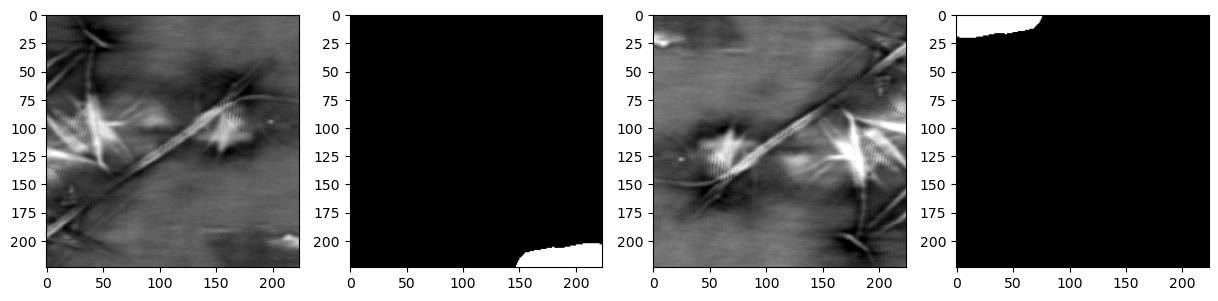

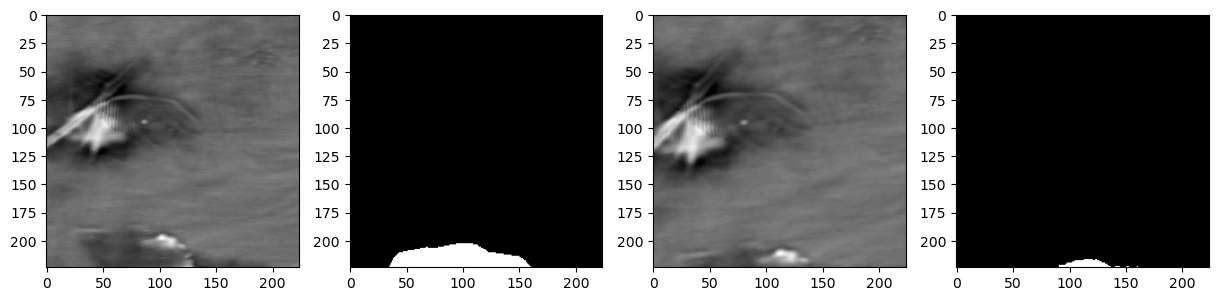

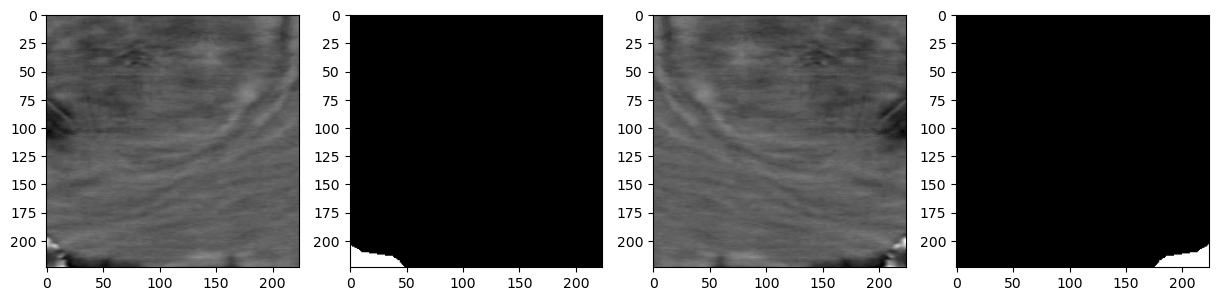

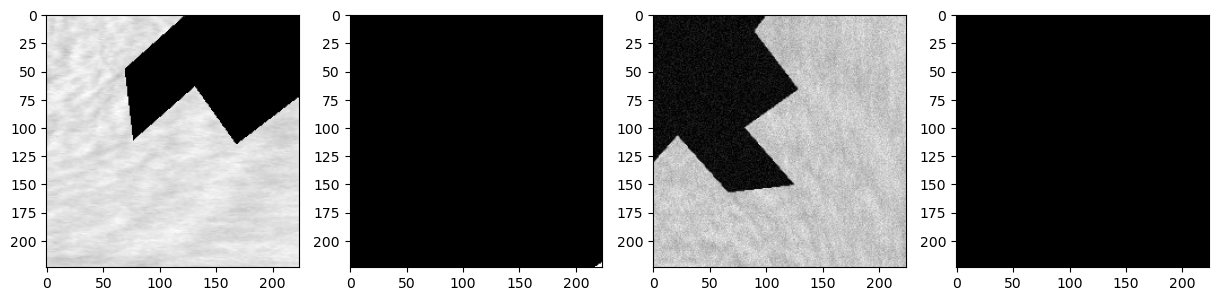

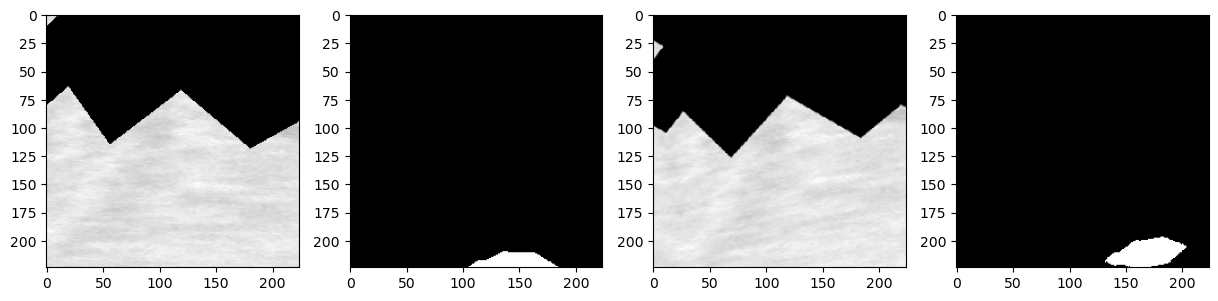

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48150

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.24750018968398282
th: 0.15, fbeta: 0.30192229654506264
th: 0.2, fbeta: 0.3518736360317128
th: 0.25, fbeta: 0.39829075561935295
th: 0.3, fbeta: 0.4254608443893874
th: 0.35, fbeta: 0.44151511163320734
th: 0.4, fbeta: 0.4419884612302014
th: 0.45, fbeta: 0.4177556323086839


best_th: 0.4, fbeta: 0.4419884612302014
Epoch 1 - avg_train_loss: 0.3907  avg_val_loss: 0.2660  time: 153s
Epoch 1 - avgScore: 0.4420
Epoch 1 - Save Best Score: 0.4420 Model
Epoch 1 - Save Best Loss: 0.2660 Model


th: 0.5, fbeta: 0.35339383258291907


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3168532045038374
th: 0.15, fbeta: 0.3563434129363688
th: 0.2, fbeta: 0.3878007185827753
th: 0.25, fbeta: 0.41909956954601596
th: 0.3, fbeta: 0.44818686955115233
th: 0.35, fbeta: 0.4744387872003183
th: 0.4, fbeta: 0.4906250474538667
th: 0.45, fbeta: 0.4998553671826535


best_th: 0.45, fbeta: 0.4998553671826535
Epoch 2 - avg_train_loss: 0.2699  avg_val_loss: 0.2381  time: 171s
Epoch 2 - avgScore: 0.4999
Epoch 2 - Save Best Score: 0.4999 Model
Epoch 2 - Save Best Loss: 0.2381 Model


th: 0.5, fbeta: 0.48860960922836033


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.3296745704947765
th: 0.15, fbeta: 0.4189454744874665
th: 0.2, fbeta: 0.45048837850914225
th: 0.25, fbeta: 0.468317382507628
th: 0.3, fbeta: 0.4501202354380115
th: 0.35, fbeta: 0.35368101485011433
th: 0.4, fbeta: 0.24054849581163246
th: 0.45, fbeta: 0.15072755862534917


best_th: 0.25, fbeta: 0.468317382507628
Epoch 3 - avg_train_loss: 0.2880  avg_val_loss: 0.2438  time: 156s
Epoch 3 - avgScore: 0.4683


th: 0.5, fbeta: 0.0782986530403404


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27982718723852684
th: 0.15, fbeta: 0.3082735657029836
th: 0.2, fbeta: 0.3368019366301545
th: 0.25, fbeta: 0.3675392170283367
th: 0.3, fbeta: 0.39868397280487416
th: 0.35, fbeta: 0.4226157478011848
th: 0.4, fbeta: 0.44084433532873674
th: 0.45, fbeta: 0.4515709497884938


best_th: 0.5, fbeta: 0.45750049336012577
Epoch 4 - avg_train_loss: 0.2704  avg_val_loss: 0.2404  time: 155s
Epoch 4 - avgScore: 0.4575


th: 0.5, fbeta: 0.45750049336012577


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2862523085918562
th: 0.15, fbeta: 0.31436309790215355
th: 0.2, fbeta: 0.34979892623273734
th: 0.25, fbeta: 0.3871212736714179
th: 0.3, fbeta: 0.41943641582042546
th: 0.35, fbeta: 0.45026420134003764
th: 0.4, fbeta: 0.4768896789316542
th: 0.45, fbeta: 0.49106743197862496


best_th: 0.5, fbeta: 0.4947446955473764
Epoch 5 - avg_train_loss: 0.2614  avg_val_loss: 0.2292  time: 154s
Epoch 5 - avgScore: 0.4947


th: 0.5, fbeta: 0.4947446955473764


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38901105664894264
th: 0.15, fbeta: 0.4341875707444396
th: 0.2, fbeta: 0.47065516583029793
th: 0.25, fbeta: 0.4996556646952238
th: 0.3, fbeta: 0.5082242063124554
th: 0.35, fbeta: 0.5041446046526575
th: 0.4, fbeta: 0.4920948296893463
th: 0.45, fbeta: 0.47343229948290777


best_th: 0.3, fbeta: 0.5082242063124554
Epoch 6 - avg_train_loss: 0.2545  avg_val_loss: 0.2359  time: 153s
Epoch 6 - avgScore: 0.5082
Epoch 6 - Save Best Score: 0.5082 Model
Epoch 6 - Save Best Loss: 0.2359 Model


th: 0.5, fbeta: 0.4425376988201676


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2981491339248487
th: 0.15, fbeta: 0.3256865104245876
th: 0.2, fbeta: 0.3515848772707447
th: 0.25, fbeta: 0.38228069214449345
th: 0.3, fbeta: 0.40916969232948
th: 0.35, fbeta: 0.4353176624273823
th: 0.4, fbeta: 0.45425509579770157
th: 0.45, fbeta: 0.46414305835006864


best_th: 0.45, fbeta: 0.46414305835006864
Epoch 7 - avg_train_loss: 0.2502  avg_val_loss: 0.2367  time: 154s
Epoch 7 - avgScore: 0.4641


th: 0.5, fbeta: 0.4628971004174117


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2678686289207217
th: 0.15, fbeta: 0.2907987432024607
th: 0.2, fbeta: 0.3147619337098616
th: 0.25, fbeta: 0.3384502874889595
th: 0.3, fbeta: 0.3640624310226577
th: 0.35, fbeta: 0.39124541530826995
th: 0.4, fbeta: 0.4158725046971869
th: 0.45, fbeta: 0.4385261447016011


best_th: 0.5, fbeta: 0.4605302257021378
Epoch 8 - avg_train_loss: 0.2448  avg_val_loss: 0.2627  time: 152s
Epoch 8 - avgScore: 0.4605


th: 0.5, fbeta: 0.4605302257021378


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32284040108376516
th: 0.15, fbeta: 0.3719213321712862
th: 0.2, fbeta: 0.41199633719076184
th: 0.25, fbeta: 0.4452485156534938
th: 0.3, fbeta: 0.46448028895270144
th: 0.35, fbeta: 0.4778979282594939
th: 0.4, fbeta: 0.4888336619149861
th: 0.45, fbeta: 0.4973066718759621


best_th: 0.5, fbeta: 0.49920446377391214
Epoch 9 - avg_train_loss: 0.2395  avg_val_loss: 0.2294  time: 152s
Epoch 9 - avgScore: 0.4992


th: 0.5, fbeta: 0.49920446377391214


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28240342149654346
th: 0.15, fbeta: 0.31302047127082966
th: 0.2, fbeta: 0.3411365124719412
th: 0.25, fbeta: 0.3686752405014011
th: 0.3, fbeta: 0.3947994657077656
th: 0.35, fbeta: 0.4196838040826896
th: 0.4, fbeta: 0.4431115339186153
th: 0.45, fbeta: 0.4657872693323151


best_th: 0.5, fbeta: 0.49214610684005283
Epoch 10 - avg_train_loss: 0.2374  avg_val_loss: 0.2408  time: 152s
Epoch 10 - avgScore: 0.4921


th: 0.5, fbeta: 0.49214610684005283


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3397779251219048
th: 0.15, fbeta: 0.37308919579640165
th: 0.2, fbeta: 0.4045309090050728
th: 0.25, fbeta: 0.42866351698352323
th: 0.3, fbeta: 0.4463295293174853
th: 0.35, fbeta: 0.4621622953917713
th: 0.4, fbeta: 0.47295187866770594
th: 0.45, fbeta: 0.4832635507776826


best_th: 0.5, fbeta: 0.48442126372194105
Epoch 11 - avg_train_loss: 0.2317  avg_val_loss: 0.2374  time: 152s
Epoch 11 - avgScore: 0.4844


th: 0.5, fbeta: 0.48442126372194105


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4390790755971701
th: 0.15, fbeta: 0.4727003099697527
th: 0.2, fbeta: 0.4881813313586581
th: 0.25, fbeta: 0.49406892966543886
th: 0.3, fbeta: 0.49148481121256127
th: 0.35, fbeta: 0.4810320564110268
th: 0.4, fbeta: 0.4602416627849025
th: 0.45, fbeta: 0.43366238994623435


best_th: 0.25, fbeta: 0.49406892966543886
Epoch 12 - avg_train_loss: 0.2269  avg_val_loss: 0.2696  time: 152s
Epoch 12 - avgScore: 0.4941


th: 0.5, fbeta: 0.40669848770893896


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3881569283560361
th: 0.15, fbeta: 0.42105549190461267
th: 0.2, fbeta: 0.4428921305721834
th: 0.25, fbeta: 0.45864644433978896
th: 0.3, fbeta: 0.468424097731307
th: 0.35, fbeta: 0.4767427688804397
th: 0.4, fbeta: 0.4813289372446202
th: 0.45, fbeta: 0.48554920095572085


best_th: 0.45, fbeta: 0.48554920095572085
Epoch 13 - avg_train_loss: 0.2245  avg_val_loss: 0.2506  time: 153s
Epoch 13 - avgScore: 0.4855


th: 0.5, fbeta: 0.4844525267133051


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3630174391964671
th: 0.15, fbeta: 0.3973924749288462
th: 0.2, fbeta: 0.4182947391484833
th: 0.25, fbeta: 0.4335291653356015
th: 0.3, fbeta: 0.4426025206018656
th: 0.35, fbeta: 0.4519321613326811
th: 0.4, fbeta: 0.4554320471273102
th: 0.45, fbeta: 0.45095430569140604


best_th: 0.4, fbeta: 0.4554320471273102
Epoch 14 - avg_train_loss: 0.2188  avg_val_loss: 0.2634  time: 152s
Epoch 14 - avgScore: 0.4554


th: 0.5, fbeta: 0.44162916376004124


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36871795069142227
th: 0.15, fbeta: 0.40851831390161364
th: 0.2, fbeta: 0.44710279679773623
th: 0.25, fbeta: 0.47684157546979006
th: 0.3, fbeta: 0.5024891046147478
th: 0.35, fbeta: 0.5263302800257089
th: 0.4, fbeta: 0.5424793665253105
th: 0.45, fbeta: 0.5534883824188883


best_th: 0.5, fbeta: 0.5620280437734231
Epoch 15 - avg_train_loss: 0.2153  avg_val_loss: 0.2189  time: 155s
Epoch 15 - avgScore: 0.5620
Epoch 15 - Save Best Score: 0.5620 Model
Epoch 15 - Save Best Loss: 0.2189 Model


th: 0.5, fbeta: 0.5620280437734231


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35779720009357857
th: 0.15, fbeta: 0.40642708414850803
th: 0.2, fbeta: 0.447242818214484
th: 0.25, fbeta: 0.4825294980699148
th: 0.3, fbeta: 0.5125217961544247
th: 0.35, fbeta: 0.5309061375434764
th: 0.4, fbeta: 0.5391091633302043
th: 0.45, fbeta: 0.5444205335984011


best_th: 0.5, fbeta: 0.5451692607626718
Epoch 16 - avg_train_loss: 0.2078  avg_val_loss: 0.2202  time: 151s
Epoch 16 - avgScore: 0.5452


th: 0.5, fbeta: 0.5451692607626718


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3499207770018208
th: 0.15, fbeta: 0.37499021121590836
th: 0.2, fbeta: 0.39483525487666216
th: 0.25, fbeta: 0.4126976901139761
th: 0.3, fbeta: 0.42866665071593946
th: 0.35, fbeta: 0.44308328721768525
th: 0.4, fbeta: 0.4564637277933708
th: 0.45, fbeta: 0.46868261779554116


best_th: 0.5, fbeta: 0.4795537640178051
Epoch 17 - avg_train_loss: 0.2030  avg_val_loss: 0.2618  time: 151s
Epoch 17 - avgScore: 0.4796


th: 0.5, fbeta: 0.4795537640178051


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39873814020549
th: 0.15, fbeta: 0.4284429905162942
th: 0.2, fbeta: 0.4508246333966485
th: 0.25, fbeta: 0.4685618182978603
th: 0.3, fbeta: 0.4839493579453865
th: 0.35, fbeta: 0.49665994607587455
th: 0.4, fbeta: 0.5063324270013756
th: 0.45, fbeta: 0.5132365453136285


best_th: 0.5, fbeta: 0.5155200821796218
Epoch 18 - avg_train_loss: 0.1955  avg_val_loss: 0.2547  time: 151s
Epoch 18 - avgScore: 0.5155


th: 0.5, fbeta: 0.5155200821796218


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36391895301865446
th: 0.15, fbeta: 0.39535360958712296
th: 0.2, fbeta: 0.42082455530273516
th: 0.25, fbeta: 0.4426854920323601
th: 0.3, fbeta: 0.4588692604986054
th: 0.35, fbeta: 0.47415615297170166
th: 0.4, fbeta: 0.4829776688153291
th: 0.45, fbeta: 0.4890038727690546


best_th: 0.5, fbeta: 0.4906585460290773
Epoch 19 - avg_train_loss: 0.1914  avg_val_loss: 0.2492  time: 151s
Epoch 19 - avgScore: 0.4907


th: 0.5, fbeta: 0.4906585460290773


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.410314692459161
th: 0.15, fbeta: 0.4363677548619487
th: 0.2, fbeta: 0.4536700106784165
th: 0.25, fbeta: 0.46491483033049896
th: 0.3, fbeta: 0.47648629279780247
th: 0.35, fbeta: 0.4853365344209437
th: 0.4, fbeta: 0.49515575608993273
th: 0.45, fbeta: 0.4997874273059451


best_th: 0.5, fbeta: 0.5043382194021038
Epoch 20 - avg_train_loss: 0.1866  avg_val_loss: 0.2693  time: 152s
Epoch 20 - avgScore: 0.5043


th: 0.5, fbeta: 0.5043382194021038


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43010807042944266
th: 0.15, fbeta: 0.4599306418444119
th: 0.2, fbeta: 0.4769906223888564
th: 0.25, fbeta: 0.4868672610923332
th: 0.3, fbeta: 0.4944408512657437
th: 0.35, fbeta: 0.5001701450110432
th: 0.4, fbeta: 0.5014793147472301
th: 0.45, fbeta: 0.4961361485956122


best_th: 0.4, fbeta: 0.5014793147472301
Epoch 21 - avg_train_loss: 0.1831  avg_val_loss: 0.2619  time: 152s
Epoch 21 - avgScore: 0.5015


th: 0.5, fbeta: 0.48509111779022074


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3794043165328687
th: 0.15, fbeta: 0.4114368013283219
th: 0.2, fbeta: 0.43954929053771075
th: 0.25, fbeta: 0.4648744921889779
th: 0.3, fbeta: 0.4892780970638676
th: 0.35, fbeta: 0.5105308482046482
th: 0.4, fbeta: 0.5272429181947482
th: 0.45, fbeta: 0.5357114152736255


best_th: 0.5, fbeta: 0.5398380178114168
Epoch 22 - avg_train_loss: 0.1767  avg_val_loss: 0.2527  time: 151s
Epoch 22 - avgScore: 0.5398


th: 0.5, fbeta: 0.5398380178114168


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39965848631650336
th: 0.15, fbeta: 0.4311061177104368
th: 0.2, fbeta: 0.4531454055125108
th: 0.25, fbeta: 0.469464772846615
th: 0.3, fbeta: 0.4855377023044261
th: 0.35, fbeta: 0.5006542981350036
th: 0.4, fbeta: 0.5113053625857046
th: 0.45, fbeta: 0.5177363483410096


best_th: 0.5, fbeta: 0.5193594106961056
Epoch 23 - avg_train_loss: 0.1717  avg_val_loss: 0.2605  time: 152s
Epoch 23 - avgScore: 0.5194


th: 0.5, fbeta: 0.5193594106961056


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37123238888168175
th: 0.15, fbeta: 0.4035645137443882
th: 0.2, fbeta: 0.43001798079346054
th: 0.25, fbeta: 0.45145299082663537
th: 0.3, fbeta: 0.4688149326944213
th: 0.35, fbeta: 0.48232563932057
th: 0.4, fbeta: 0.49535661440852563
th: 0.45, fbeta: 0.5054479279542294


best_th: 0.5, fbeta: 0.5141426032036754
Epoch 24 - avg_train_loss: 0.1658  avg_val_loss: 0.2478  time: 152s
Epoch 24 - avgScore: 0.5141


th: 0.5, fbeta: 0.5141426032036754


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4727348295332739
th: 0.15, fbeta: 0.50127743786052
th: 0.2, fbeta: 0.5226011608045132
th: 0.25, fbeta: 0.535929172911443
th: 0.3, fbeta: 0.5430017980587681
th: 0.35, fbeta: 0.5453070876079389
th: 0.4, fbeta: 0.5441491240408775
th: 0.45, fbeta: 0.5372882249546522


best_th: 0.35, fbeta: 0.5453070876079389
Epoch 25 - avg_train_loss: 0.1651  avg_val_loss: 0.2865  time: 152s
Epoch 25 - avgScore: 0.5453


th: 0.5, fbeta: 0.5260578702614581


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3980559344756547
th: 0.15, fbeta: 0.4312403190647948
th: 0.2, fbeta: 0.45546647493394815
th: 0.25, fbeta: 0.47657665232998914
th: 0.3, fbeta: 0.49535420469352476
th: 0.35, fbeta: 0.5127217158873615
th: 0.4, fbeta: 0.5260684150387007
th: 0.45, fbeta: 0.5350056915608893


best_th: 0.5, fbeta: 0.543738722875993
Epoch 26 - avg_train_loss: 0.1607  avg_val_loss: 0.2488  time: 151s
Epoch 26 - avgScore: 0.5437


th: 0.5, fbeta: 0.543738722875993


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40317869566598014
th: 0.15, fbeta: 0.43021264061028475
th: 0.2, fbeta: 0.4482237950456944
th: 0.25, fbeta: 0.46575150075048416
th: 0.3, fbeta: 0.4815378459842337
th: 0.35, fbeta: 0.49728712763022853
th: 0.4, fbeta: 0.5083261816687885
th: 0.45, fbeta: 0.5149611730584756


best_th: 0.5, fbeta: 0.5202991159531537
Epoch 27 - avg_train_loss: 0.1559  avg_val_loss: 0.2707  time: 152s
Epoch 27 - avgScore: 0.5203


th: 0.5, fbeta: 0.5202991159531537


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4026975217502381
th: 0.15, fbeta: 0.4290558972063733
th: 0.2, fbeta: 0.450919845682403
th: 0.25, fbeta: 0.4694260114555905
th: 0.3, fbeta: 0.48558230474579916
th: 0.35, fbeta: 0.5009339172744044
th: 0.4, fbeta: 0.5131127606563289
th: 0.45, fbeta: 0.5221412803866895


best_th: 0.5, fbeta: 0.5271820962973088
Epoch 28 - avg_train_loss: 0.1552  avg_val_loss: 0.2715  time: 152s
Epoch 28 - avgScore: 0.5272


th: 0.5, fbeta: 0.5271820962973088


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42044863998209087
th: 0.15, fbeta: 0.44898718858938513
th: 0.2, fbeta: 0.46903914012207326
th: 0.25, fbeta: 0.4830129410691031
th: 0.3, fbeta: 0.4942489079431963
th: 0.35, fbeta: 0.5047304193779537
th: 0.4, fbeta: 0.5131880868965939
th: 0.45, fbeta: 0.520622163410656


best_th: 0.5, fbeta: 0.5249525609619757
Epoch 29 - avg_train_loss: 0.1505  avg_val_loss: 0.2865  time: 152s
Epoch 29 - avgScore: 0.5250


th: 0.5, fbeta: 0.5249525609619757


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3820456112033589
th: 0.15, fbeta: 0.40966889485287356
th: 0.2, fbeta: 0.4297234968625314
th: 0.25, fbeta: 0.44810792860095044
th: 0.3, fbeta: 0.4665175370940147
th: 0.35, fbeta: 0.48054728550128517
th: 0.4, fbeta: 0.49160108583608253
th: 0.45, fbeta: 0.501266090014514


best_th: 0.5, fbeta: 0.5113282783132388
Epoch 30 - avg_train_loss: 0.1488  avg_val_loss: 0.2673  time: 152s
Epoch 30 - avgScore: 0.5113


th: 0.5, fbeta: 0.5113282783132388


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.36871795069142227
th: 0.15, fbeta: 0.40851831390161364
th: 0.2, fbeta: 0.44710279679773623
th: 0.25, fbeta: 0.47684157546979006
th: 0.3, fbeta: 0.5024891046147478
th: 0.35, fbeta: 0.5263302800257089
th: 0.4, fbeta: 0.5424793665253105
th: 0.45, fbeta: 0.5534883824188883


best_th: 0.5, fbeta: 0.5620280437734231


th: 0.5, fbeta: 0.5620280437734231


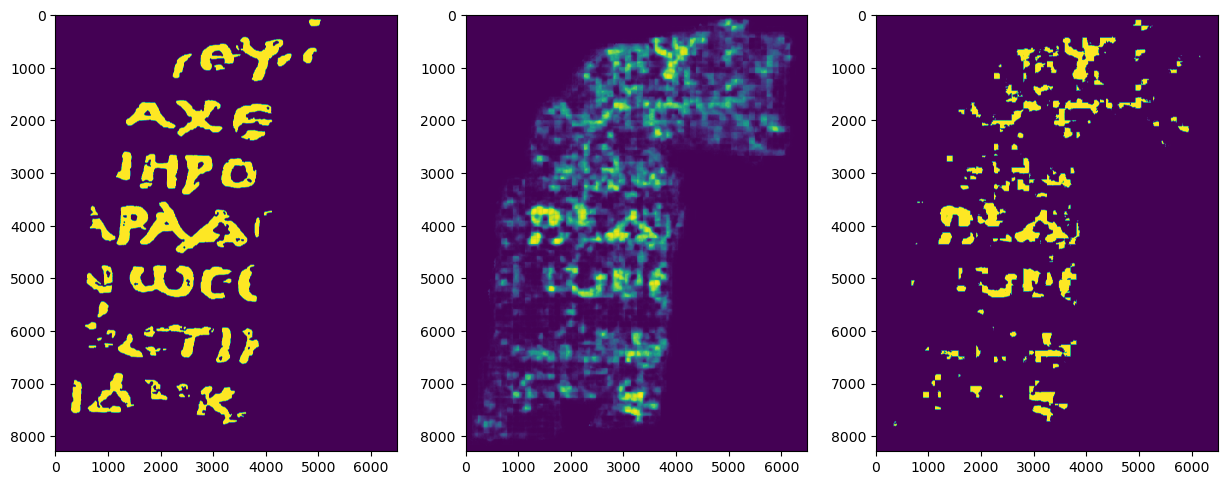

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([35839271.,  4260500.,  2629455.,  1997497.,  1465871.,  1258635.,
         1048402.,   851338.,   733478.,   654434.,   575898.,   475833.,
          399083.,   341858.,   307101.,   291552.,   236351.,   192825.,
          177458.,   102008.]),
 array([4.11431802e-06, 4.96974685e-02, 9.93908226e-02, 1.49084177e-01,
        1.98777531e-01, 2.48470885e-01, 2.98164239e-01, 3.47857593e-01,
        3.97550947e-01, 4.47244302e-01, 4.96937656e-01, 5.46631010e-01,
        5.96324364e-01, 6.46017718e-01, 6.95711072e-01, 7.45404426e-01,
        7.95097781e-01, 8.44791135e-01, 8.94484489e-01, 9.44177843e-01,
        9.93871197e-01]),
 <BarContainer object of 20 artists>)

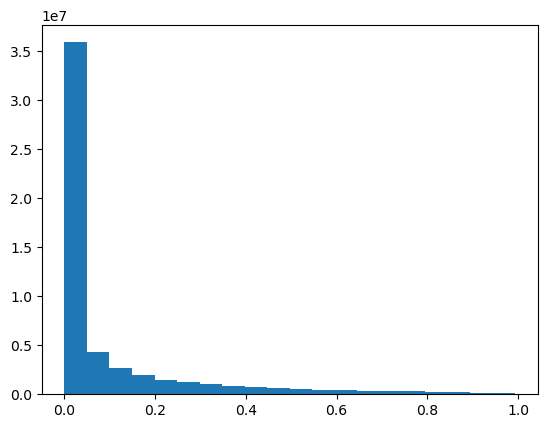

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000